In [1]:
import lammps
import random
from tqdm import trange
import pymc3 as pm
import arviz as az
import numpy as np
import pymatgen as pmg
import theano.tensor as tt
import glob
from copy import deepcopy

In [2]:
elements = pmg.Element('Li'), pmg.Element('Ni'), pmg.Element('O')
li, ni, o = elements

pairs = [(li,o), (ni,o), (o,o)]

charges = {li: 1,
           ni: 3,
           o: -2}

bpp_def = {'Li_O_A'   : 456.783,
           'Li_O_rho' : 0.212,
           'Li_O_C'   : 0.0,
           'Ni_O_A'   : 1540.922,
           'Ni_O_rho' : 0.323,
           'Ni_O_C'   : 0.425,
           'O_O_A'    : 22764.7000,
           'O_O_rho'  : 0.1490,
           'O_O_C'    : 20.4}

bpp = deepcopy(bpp_def)

In [3]:
structures = []
for structure in glob.glob('../poscars/POSCAR*'):
    st = pmg.Structure.from_file(structure)
    structures.append(st)

In [4]:
def init(structure):
    lmp = lammps.Lammps(units='metal',
                        style = 'full',
                        args=['-log', 'none', '-screen', 'none'])
    lmp.system.add_pymatgen_structure(structure, elements)
    lmp.command('kspace_style pppm 1e-6')
    lmp.command('pair_style buck/coul/long 12.0')
    lmp.command('pair_coeff * * 0 1 0')

    for c in charges:
        lmp.command('set type %d charge %f' % (elements.index(c)+1, charges[c]))
    
    return lmp

In [5]:
def update_potentials(**kwargs):
    bpp.update(kwargs)
def set_potentials(instance):
    for pair in pairs:
        instance.command('pair_coeff {} {} {} {} {}'.format(dex(pair[0]),
                                                            dex(pair[1]),
                                                            bpp['{}_{}_A'.format(pair[0], pair[1])],
                                                            bpp['{}_{}_rho'.format(pair[0], pair[1])],
                                                            bpp['{}_{}_C'.format(pair[0], pair[1])]))
        
def dex(elin): return elements.index(elin) + 1

In [6]:
def simfunc(**kwargs):
    if min(kwargs.values()) > 0:
        update_potentials(**kwargs)
        out = np.zeros([instances[0].system.total,3, len(instances)])
        
        for instance in instances:
            set_potentials(instance)
            instance.run(0)
            out[:,:,instances.index(instance)] = instance.system.forces
            
    else: out = np.ones([instances[0].system.total,3, len(instances)])*999999999 # ThisAlgorithmBecomingSkynetCost
        
    return out

In [7]:
instances = [init(structure) for structure in structures]

In [8]:
expected = np.zeros([instances[0].system.total,3, len(instances)])

In [9]:
with pm.Model() as model:
    Li_O_A      = pm.Normal("Li_O_A",    mu = bpp_def['Li_O_A'],    sd =  100)
    Li_O_rho    = pm.Normal("Li_O_rho",  mu = bpp_def['Li_O_rho'],  sd =  0.05)
#     Li_O_C      = pm.Normal("Li_O_C",    mu = bpp_def['Li_O_C'],    sd =  0.01)
    Ni_O_A      = pm.Normal("Ni_O_A",    mu = bpp_def['Ni_O_A'],    sd =  100)
    Ni_O_rho    = pm.Normal("Ni_O_rho",  mu = bpp_def['Ni_O_rho'],  sd =  0.05)
    Ni_O_C      = pm.Normal("Ni_O_C",    mu = bpp_def['Ni_O_C'],    sd =  0.05)
    O_O_A       = pm.Normal("O_O_A",     mu = bpp_def['O_O_A'],     sd =  100)
    O_O_rho     = pm.Normal("O_O_rho",   mu = bpp_def['O_O_rho'],   sd =  0.05)
    O_O_C       = pm.Normal("O_O_C",     mu = bpp_def['O_O_C'],     sd =  5)
    
    simulator = pm.Simulator('simulator', simfunc, observed=expected)
    
    trace = pm.sample(step=pm.SMC(ABC=True, epsilon=1), draws=500)

Sample initial stage: ...
/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pymc3/step_methods/smc.py:176: UserWarning: Warning: SMC-ABC methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Stage: 0 Beta: 0.014 Steps: 25
Stage: 1 Beta: 0.095 Steps: 22
Stage: 2 Beta: 0.410 Steps: 2
Stage: 3 Beta: 1.000 Steps: 17


/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131eca080>,
      dtype=object)

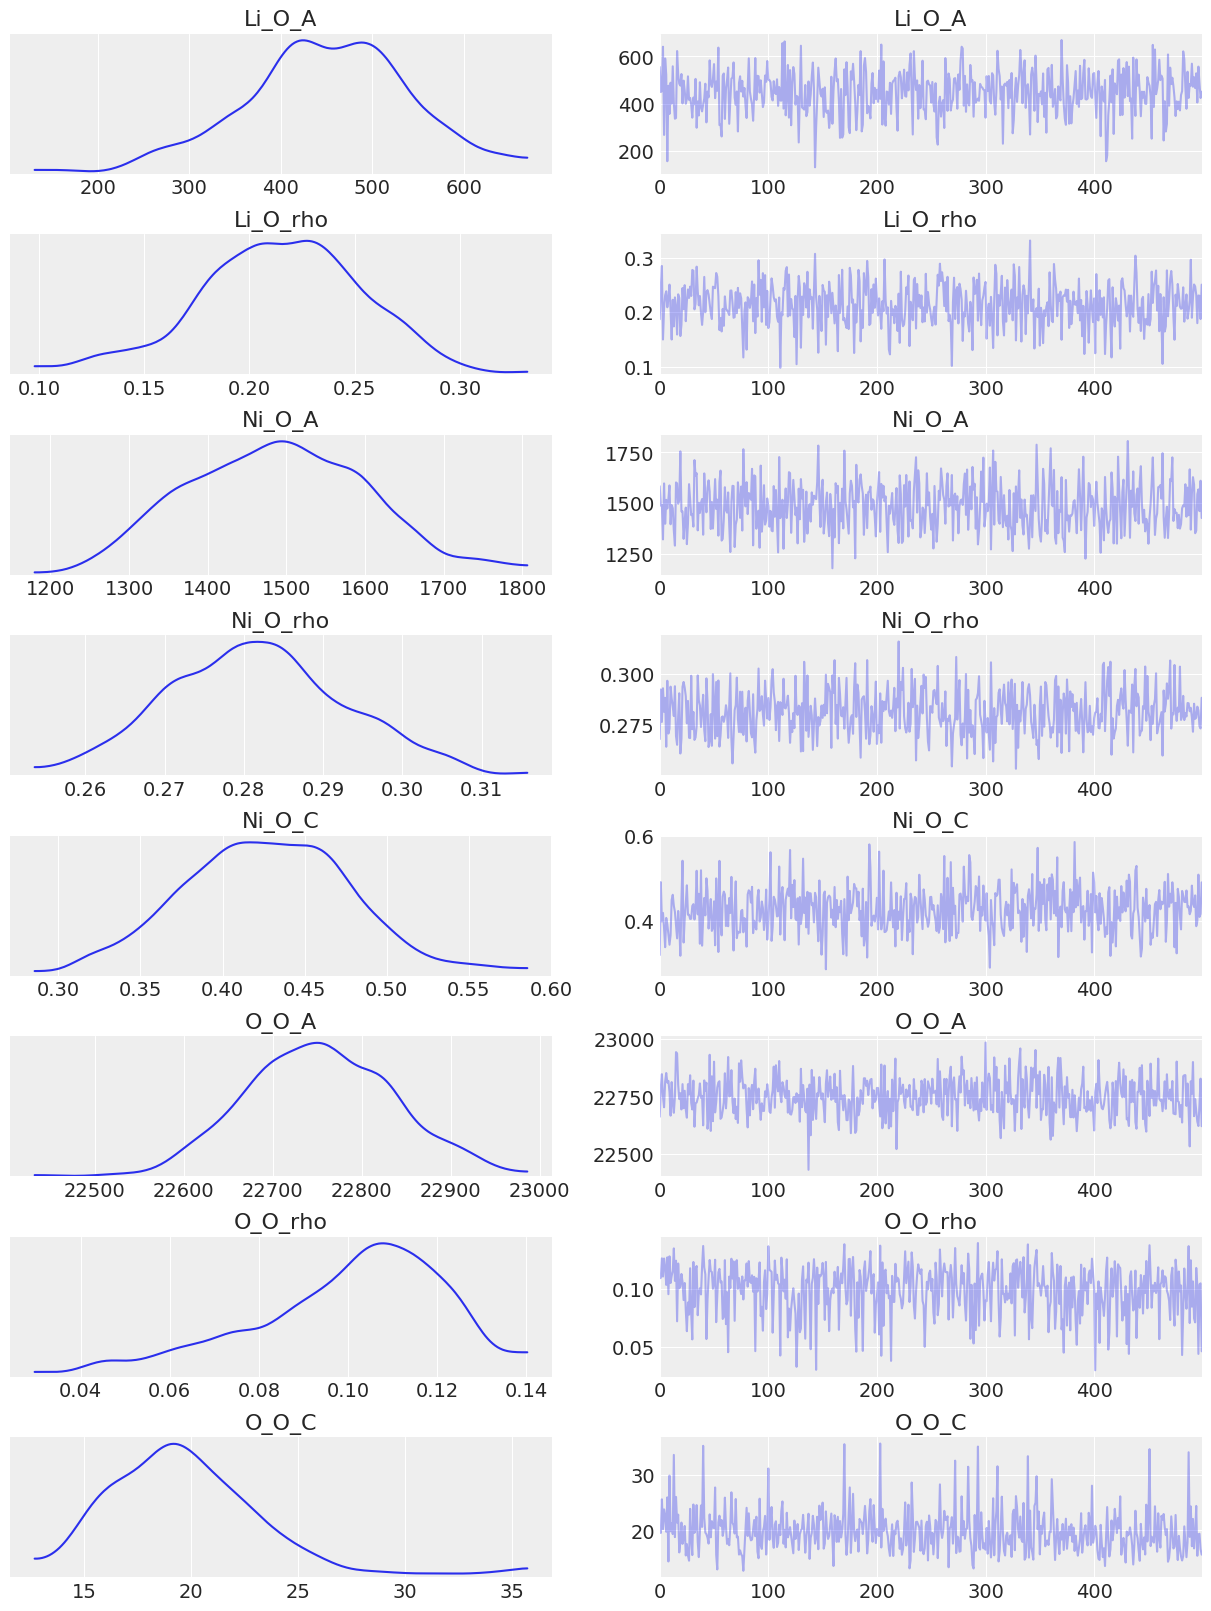

In [10]:
az.style.use('arviz-darkgrid')
az.plot_trace(trace)

/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1345fe278>,
      dtype=object)

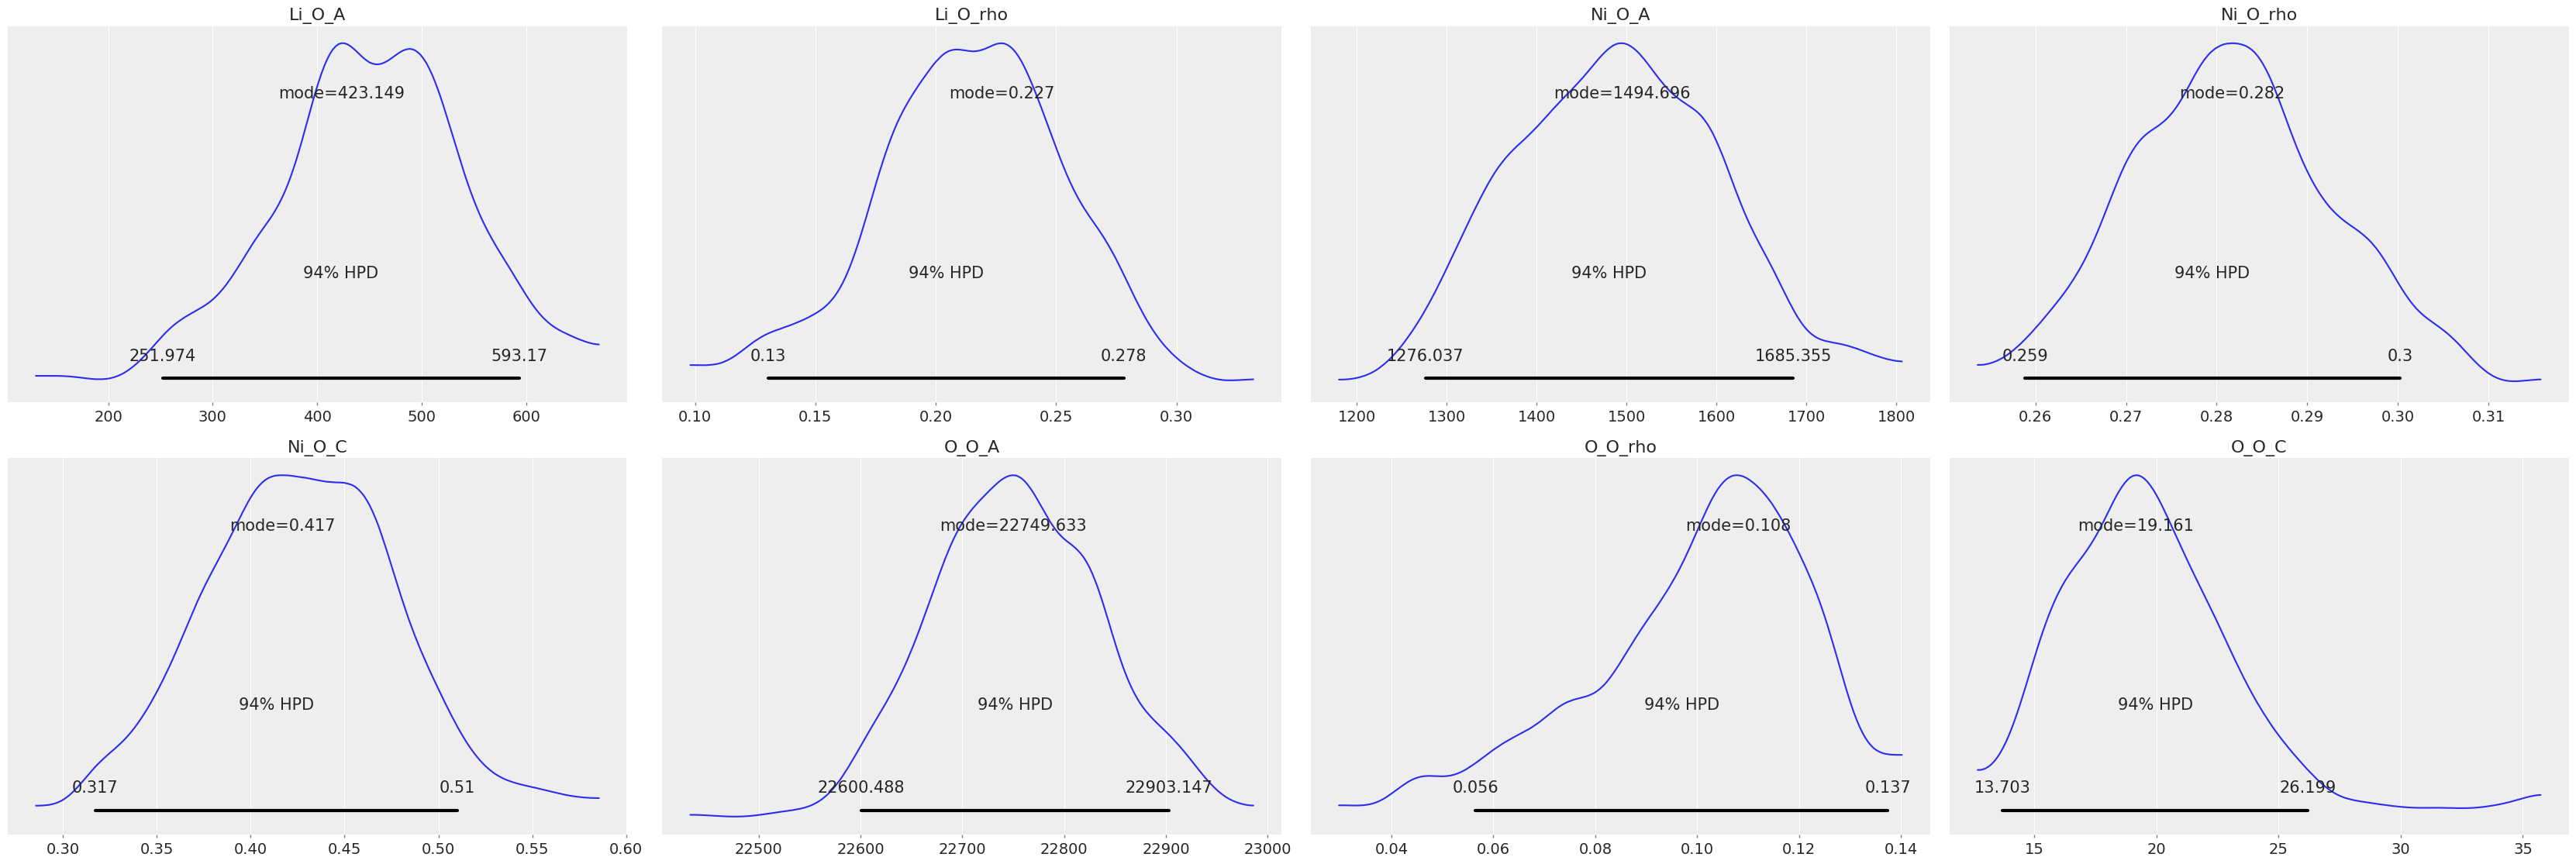

In [11]:
az.plot_posterior(trace, round_to = 3, point_estimate = 'mode')